In [5]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
sns.set_theme(style="whitegrid")


In [6]:
def process_crop(file_path):
    # Load dataset
    data = pd.read_csv(file_path)
    crop_name = file_path.split('/')[-1].split('_')[0]  # Extract crop name from file name

    # One-hot encode DISTRICT_NAME
    data = pd.get_dummies(data, columns=['DISTRICT_NAME'], prefix='DISTRICT', drop_first=True)

    # Removing outliers using IQR method
    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

    # Prepare features (X) and target (y)
    X = data.drop(columns=['YEAR', 'CROP_TYPE', 'PRODUCTION'])
    y = data['PRODUCTION']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features for SVR
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    svr_model = SVR(kernel='linear', C=10, epsilon=0.5)

    # ridge regression added
    ridge_model = Ridge()
    ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
    ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='r2')
    ridge_grid.fit(X_train, y_train)
    best_ridge_model = ridge_grid.best_estimator_

    lr_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    svr_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_lr = lr_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_test)
    y_pred_svr = svr_model.predict(X_test_scaled)
    y_pred_ridge = best_ridge_model.predict(X_test)

    # Evaluate models
    results = {
        "Crop": crop_name,
        "Model": ["Linear Regression", "Random Forest", "SVR", "Ridge Regression"],
        "MAE": [
            mean_absolute_error(y_test, y_pred_lr),
            mean_absolute_error(y_test, y_pred_rf),
            mean_absolute_error(y_test, y_pred_svr),
            mean_absolute_error(y_test, y_pred_ridge),

        ],
        "RMSE": [
            np.sqrt(mean_squared_error(y_test, y_pred_lr)),
            np.sqrt(mean_squared_error(y_test, y_pred_rf)),
            np.sqrt(mean_squared_error(y_test, y_pred_svr)),
            np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
        ],
        "R²": [
            r2_score(y_test, y_pred_lr),
            r2_score(y_test, y_pred_rf),
            r2_score(y_test, y_pred_svr),
            r2_score(y_test, y_pred_ridge),
        ],
    }

    # Feature importance for Random Forest
    feature_importances = rf_model.feature_importances_
    importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": feature_importances}
    ).sort_values(by="Importance", ascending=False).head(10)

    return results, y_test, y_pred_lr, y_pred_rf, y_pred_svr, y_pred_ridge, importance_df

In [7]:
def visualize_influencers(importance_df, crop_name):
    # Remove AREA from the feature list
    filtered_importance_df = importance_df[importance_df['Feature'] != 'AREA'].copy()

    # Normalize the importance values to represent percentages
    filtered_importance_df.loc[:, 'Normalized Importance (%)'] = (
        filtered_importance_df['Importance'] / filtered_importance_df['Importance'].sum() * 100
    )

    # Display the normalized importance DataFrame
    print(f"Normalized Feature Importances for {crop_name}:")
    display(filtered_importance_df)

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(
        filtered_importance_df['Normalized Importance (%)'], 
        labels=filtered_importance_df['Feature'], 
        autopct='%1.1f%%', 
        startangle=140,
        colors=sns.color_palette('pastel')
    )
    plt.title(f"Feature Importance Distribution - {crop_name}")
    plt.show()


Top 10 Features for BARLEY - Random Forest


,Feature,Importance
0,AREA,0.925849
7,SUMMER_RAINFALL,0.007720
8,WINTER_RAINFALL,0.005995
14,SPRING_WIND_SPEED,0.005462
6,SPRING_RAINFALL,0.005358
16,WINTER_WIND_SPEED,0.004507
5,AUTUMN_RAINFALL,0.004239
4,WINTER_HUMIDITY,0.004041
2,SPRING_HUMIDITY,0.003778
11,SUMMER_TEMPERATURE,0.003557


Normalized Feature Importances for BARLEY:


,Feature,Importance,Normalized Importance (%)
7,SUMMER_RAINFALL,0.007720,17.286257
8,WINTER_RAINFALL,0.005995,13.424992
14,SPRING_WIND_SPEED,0.005462,12.231489
6,SPRING_RAINFALL,0.005358,11.998986
16,WINTER_WIND_SPEED,0.004507,10.092352
5,AUTUMN_RAINFALL,0.004239,9.492736
4,WINTER_HUMIDITY,0.004041,9.048456
2,SPRING_HUMIDITY,0.003778,8.460093
11,SUMMER_TEMPERATURE,0.003557,7.964639


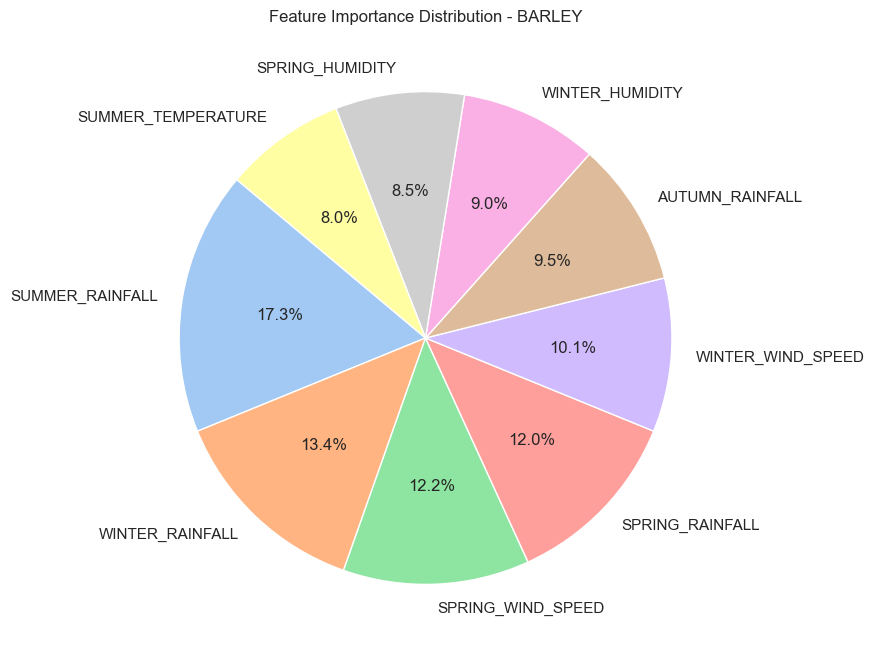

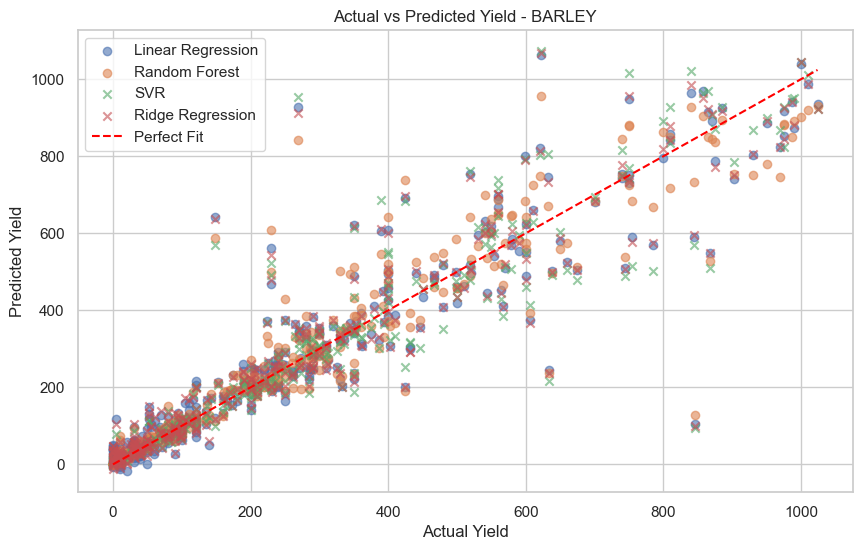

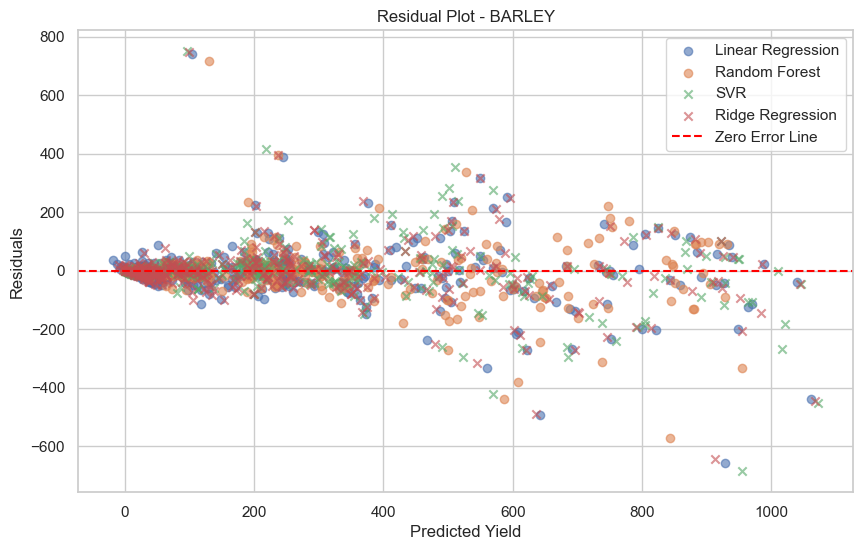

Top 10 Features for MAIZE - Random Forest


,Feature,Importance
0,AREA,0.853026
2,SPRING_HUMIDITY,0.030937
7,SUMMER_RAINFALL,0.012675
14,SPRING_WIND_SPEED,0.011613
4,WINTER_HUMIDITY,0.010448
6,SPRING_RAINFALL,0.007468
8,WINTER_RAINFALL,0.007221
13,AUTUMN_WIND_SPEED,0.006887
15,SUMMER_WIND_SPEED,0.006497
3,SUMMER_HUMIDITY,0.006254


Normalized Feature Importances for MAIZE:


,Feature,Importance,Normalized Importance (%)
2,SPRING_HUMIDITY,0.030937,30.936462
7,SUMMER_RAINFALL,0.012675,12.675053
14,SPRING_WIND_SPEED,0.011613,11.612734
4,WINTER_HUMIDITY,0.010448,10.448445
6,SPRING_RAINFALL,0.007468,7.467906
8,WINTER_RAINFALL,0.007221,7.220986
13,AUTUMN_WIND_SPEED,0.006887,6.887287
15,SUMMER_WIND_SPEED,0.006497,6.496661
3,SUMMER_HUMIDITY,0.006254,6.254465


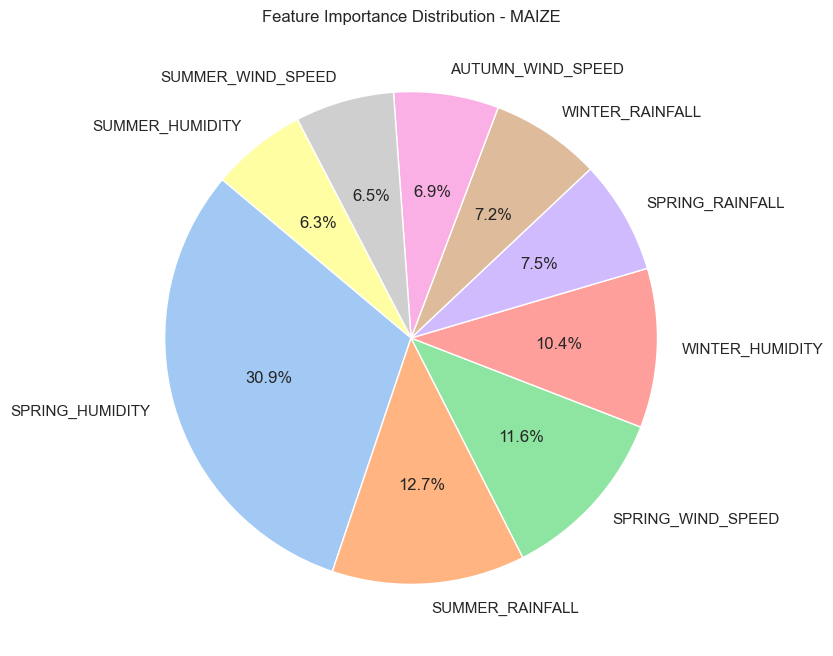

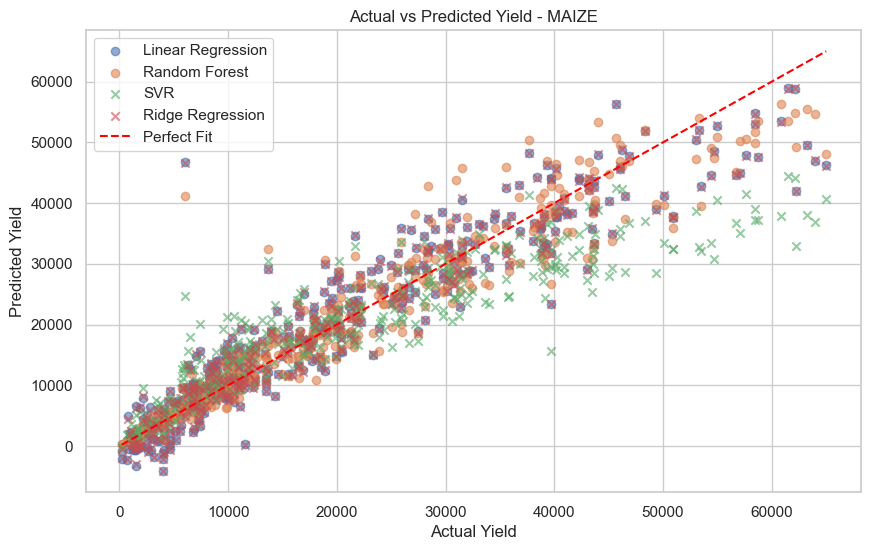

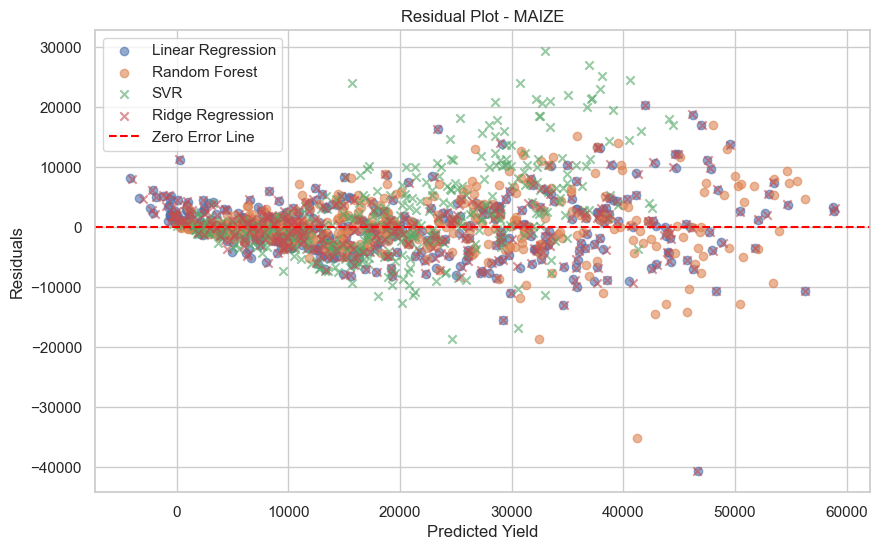

Top 10 Features for MILLET - Random Forest


,Feature,Importance
0,AREA,0.942251
3,SUMMER_HUMIDITY,0.006948
12,WINTER_TEMPERATURE,0.005139
37,DISTRICT_DOTI,0.004679
16,WINTER_WIND_SPEED,0.003459
31,DISTRICT_DARCHULA,0.003441
1,AUTUMN_HUMIDITY,0.003234
15,SUMMER_WIND_SPEED,0.002736
6,SPRING_RAINFALL,0.002265
8,WINTER_RAINFALL,0.002245


Normalized Feature Importances for MILLET:


,Feature,Importance,Normalized Importance (%)
3,SUMMER_HUMIDITY,0.006948,20.348221
12,WINTER_TEMPERATURE,0.005139,15.049407
37,DISTRICT_DOTI,0.004679,13.704034
16,WINTER_WIND_SPEED,0.003459,10.128618
31,DISTRICT_DARCHULA,0.003441,10.078158
1,AUTUMN_HUMIDITY,0.003234,9.471142
15,SUMMER_WIND_SPEED,0.002736,8.013951
6,SPRING_RAINFALL,0.002265,6.632989
8,WINTER_RAINFALL,0.002245,6.573478


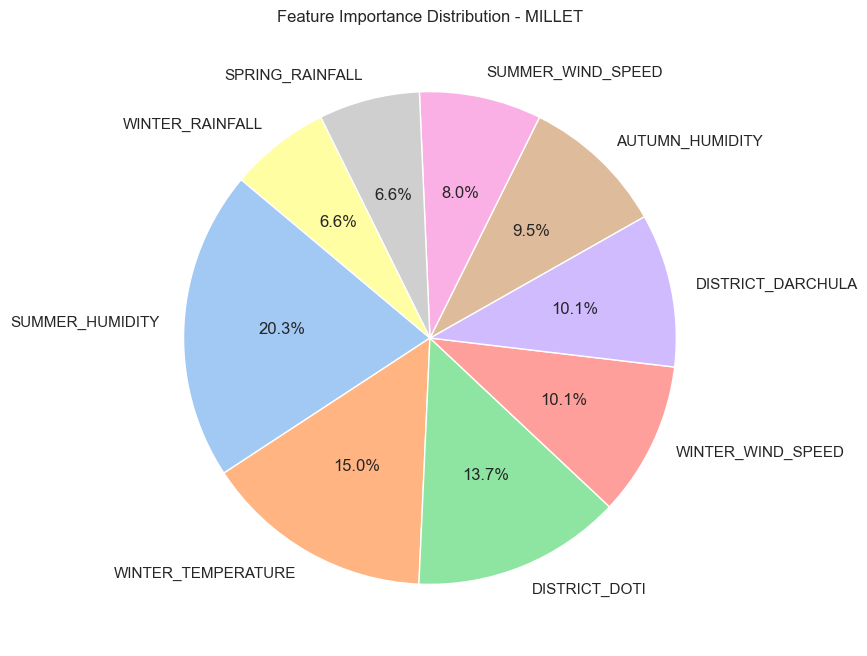

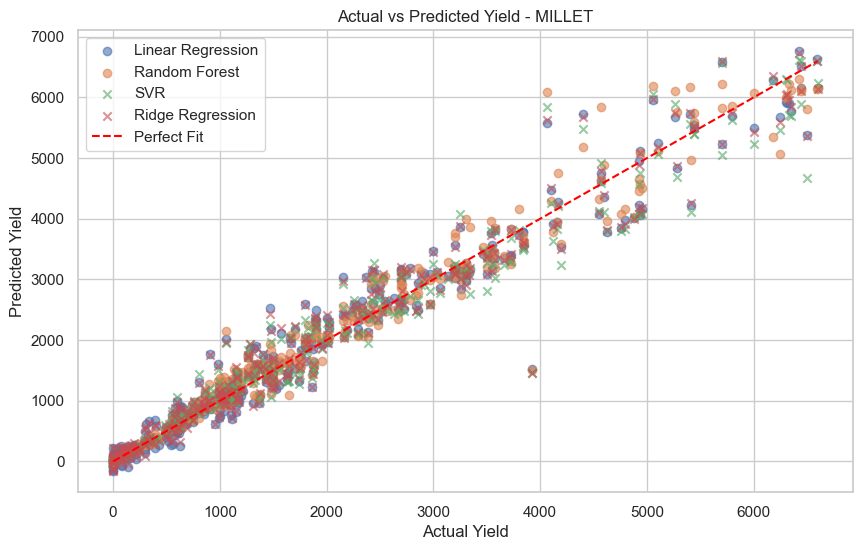

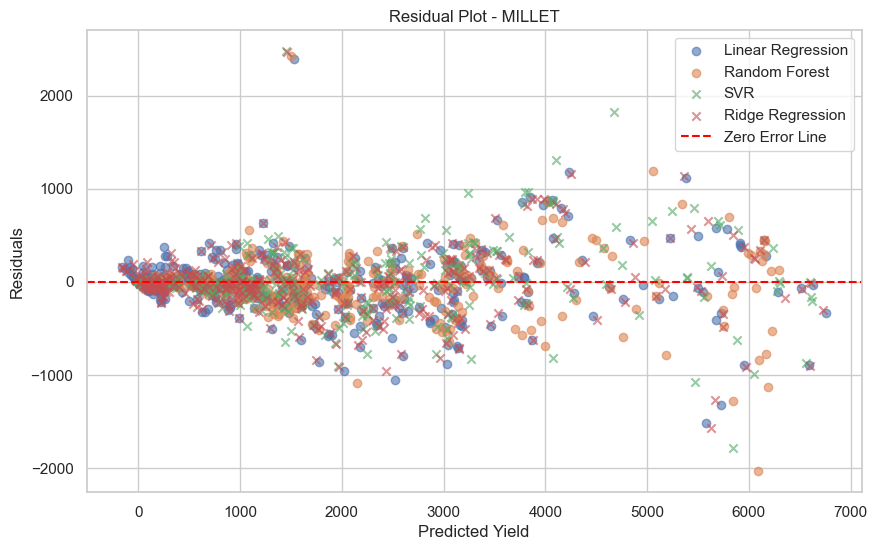

Top 10 Features for PADDY - Random Forest


,Feature,Importance
0,AREA,0.917002
50,DISTRICT_KATHMANDU,0.012181
15,SUMMER_WIND_SPEED,0.008149
3,SUMMER_HUMIDITY,0.006889
7,SUMMER_RAINFALL,0.005689
2,SPRING_HUMIDITY,0.005280
1,AUTUMN_HUMIDITY,0.004882
8,WINTER_RAINFALL,0.004544
4,WINTER_HUMIDITY,0.003231
13,AUTUMN_WIND_SPEED,0.002992


Normalized Feature Importances for PADDY:


,Feature,Importance,Normalized Importance (%)
50,DISTRICT_KATHMANDU,0.012181,22.626594
15,SUMMER_WIND_SPEED,0.008149,15.136487
3,SUMMER_HUMIDITY,0.006889,12.796089
7,SUMMER_RAINFALL,0.005689,10.566980
2,SPRING_HUMIDITY,0.005280,9.807195
1,AUTUMN_HUMIDITY,0.004882,9.067589
8,WINTER_RAINFALL,0.004544,8.440585
4,WINTER_HUMIDITY,0.003231,6.000927
13,AUTUMN_WIND_SPEED,0.002992,5.557554


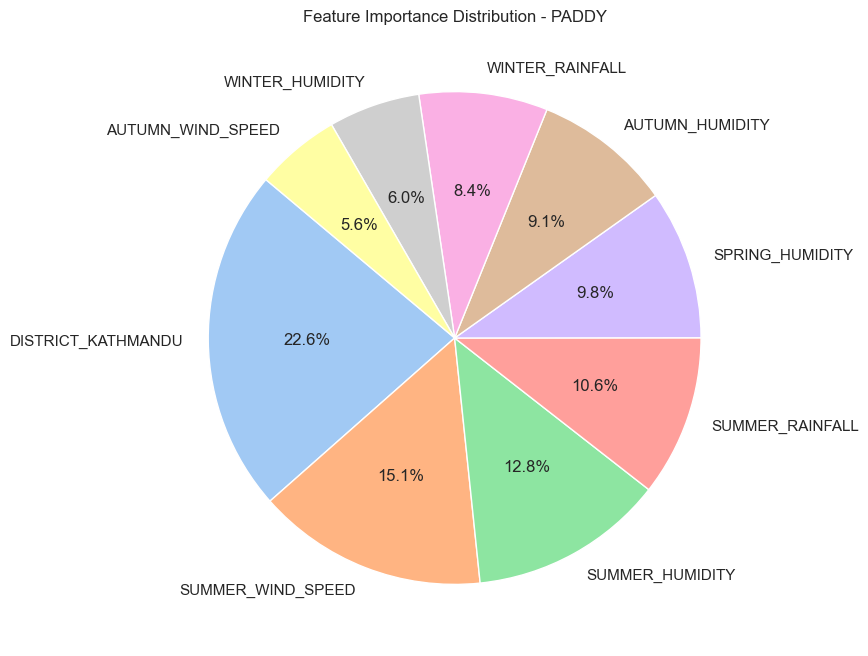

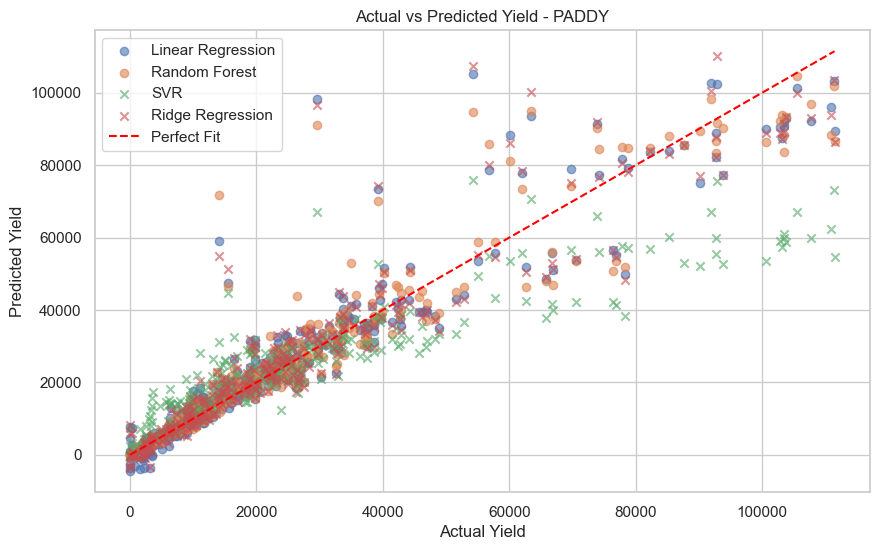

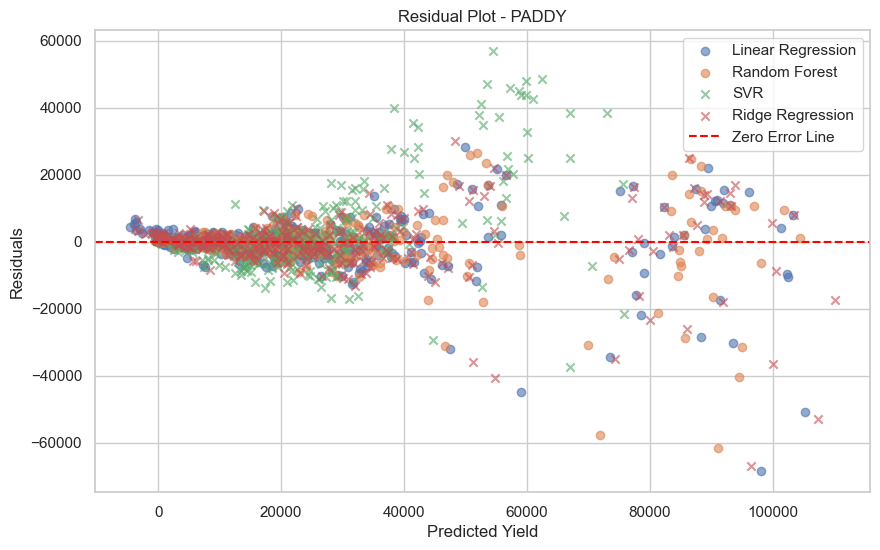

Top 10 Features for WHEAT - Random Forest


,Feature,Importance
0,AREA,0.857411
2,SPRING_HUMIDITY,0.015723
3,SUMMER_HUMIDITY,0.014348
13,AUTUMN_WIND_SPEED,0.012776
7,SUMMER_RAINFALL,0.011572
1,AUTUMN_HUMIDITY,0.010308
4,WINTER_HUMIDITY,0.009634
8,WINTER_RAINFALL,0.008199
5,AUTUMN_RAINFALL,0.007984
6,SPRING_RAINFALL,0.006277


Normalized Feature Importances for WHEAT:


,Feature,Importance,Normalized Importance (%)
2,SPRING_HUMIDITY,0.015723,16.239471
3,SUMMER_HUMIDITY,0.014348,14.818859
13,AUTUMN_WIND_SPEED,0.012776,13.195340
7,SUMMER_RAINFALL,0.011572,11.951728
1,AUTUMN_HUMIDITY,0.010308,10.646303
4,WINTER_HUMIDITY,0.009634,9.950435
8,WINTER_RAINFALL,0.008199,8.468448
5,AUTUMN_RAINFALL,0.007984,8.246520
6,SPRING_RAINFALL,0.006277,6.482897


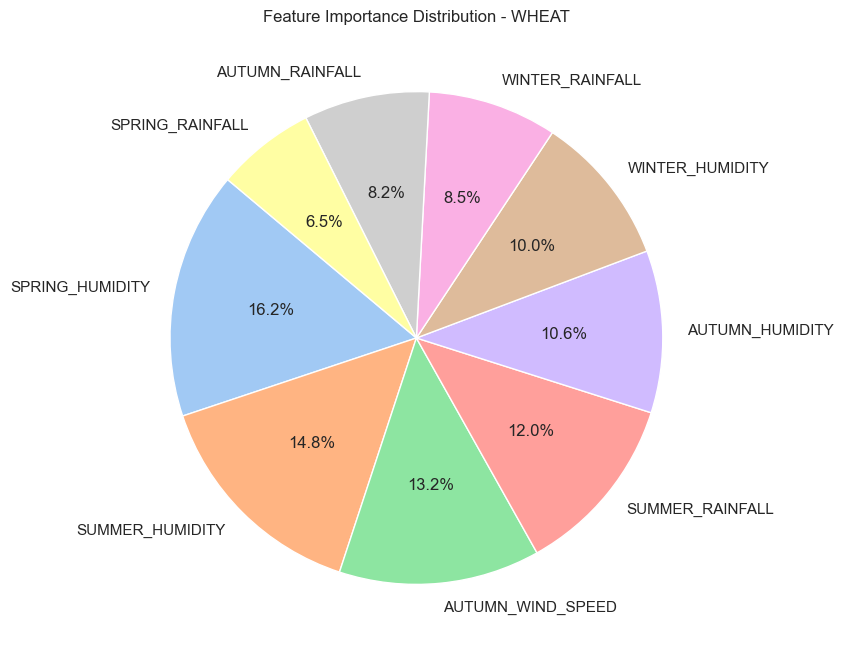

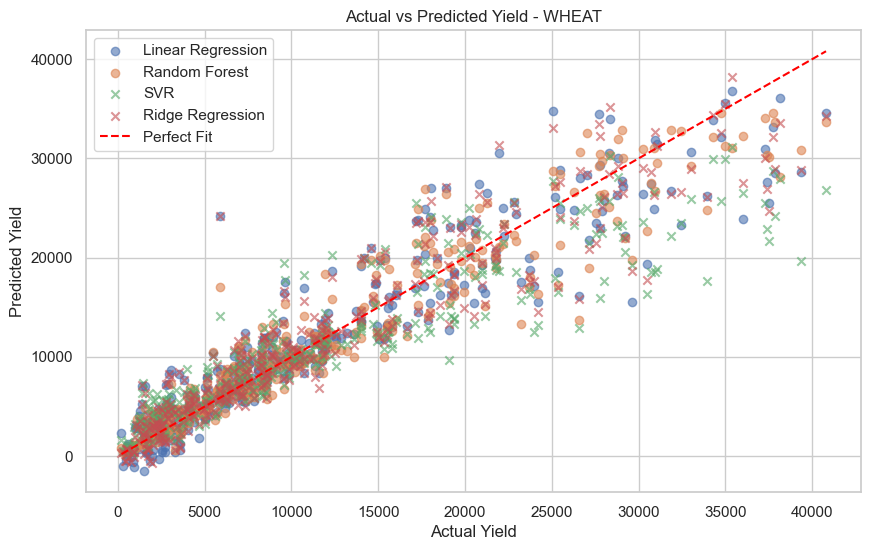

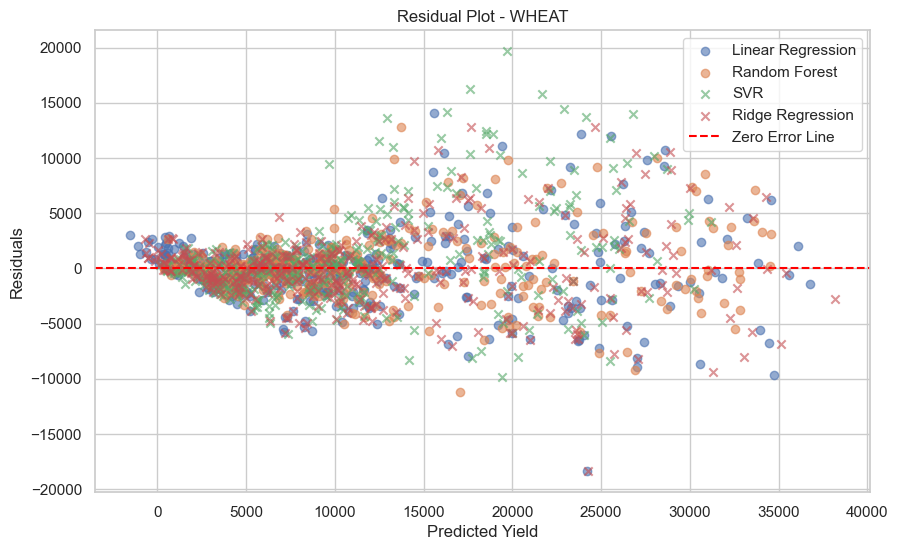

In [9]:
# List of file paths
file_paths = [
    "FinalDatasets/BARLEY_data_merged.csv",
    "FinalDatasets/MAIZE_data_merged.csv",
    "FinalDatasets/MILLET_data_merged.csv",
    "FinalDatasets/PADDY_data_merged.csv",
    "FinalDatasets/WHEAT_data_merged.csv",
]

# Initialize summary DataFrame
summary_df = pd.DataFrame()

# Loop through each crop
for file_path in file_paths:
    results, y_test, y_pred_lr, y_pred_rf, y_pred_svr,y_pred_ridge, importance_df = process_crop(file_path)

    # Append results to summary DataFrame
    summary_df = pd.concat([summary_df, pd.DataFrame(results)], ignore_index=True)

    # Display crop-specific feature importance
    crop_name = results["Crop"]
    print(f"Top 10 Features for {crop_name} - Random Forest")
    display(importance_df)  # Jupyter-friendly display

    # Call the visualization function
    visualize_influencers(importance_df, crop_name)

    # Scatter plot: Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_lr, label="Linear Regression", alpha=0.6)
    plt.scatter(y_test, y_pred_rf, label="Random Forest", alpha=0.6)
    plt.scatter(y_test, y_pred_svr, label="SVR", alpha=0.6, marker="x")
    plt.scatter(y_test, y_pred_ridge, label="Ridge Regression", alpha=0.6, marker="x")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red", label="Perfect Fit")
    plt.title(f"Actual vs Predicted Yield - {crop_name}")
    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.legend()
    plt.show()

    # Residual plots
    residuals_lr = y_test - y_pred_lr
    residuals_rf = y_test - y_pred_rf
    residuals_svr = y_test - y_pred_svr
    residuals_ridge = y_test - y_pred_ridge

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_lr, residuals_lr, label="Linear Regression", alpha=0.6)
    plt.scatter(y_pred_rf, residuals_rf, label="Random Forest", alpha=0.6)
    plt.scatter(y_pred_svr, residuals_svr, label="SVR", alpha=0.6, marker="x")
    plt.scatter(y_pred_ridge, residuals_ridge, label="Ridge Regression", alpha=0.6, marker="x")
    plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
    plt.title(f"Residual Plot - {crop_name}")
    plt.xlabel("Predicted Yield")
    plt.ylabel("Residuals")
    plt.legend()
    plt.show()

Model Performance Summary:


,Crop,Model,MAE,RMSE,R²
0,BARLEY,Linear Regression,50.28,93.74,0.86
1,BARLEY,Random Forest,42.14,86.29,0.88
2,BARLEY,SVR,44.18,94.30,0.86
3,BARLEY,Ridge Regression,49.60,93.50,0.86
4,MAIZE,Linear Regression,3599.74,5106.12,0.89
5,MAIZE,Random Forest,2889.42,4592.59,0.91
6,MAIZE,SVR,4898.95,7273.14,0.77
7,MAIZE,Ridge Regression,3598.41,5117.35,0.89
8,MILLET,Linear Regression,224.24,340.74,0.96
9,MILLET,Random Forest,180.96,310.90,0.96


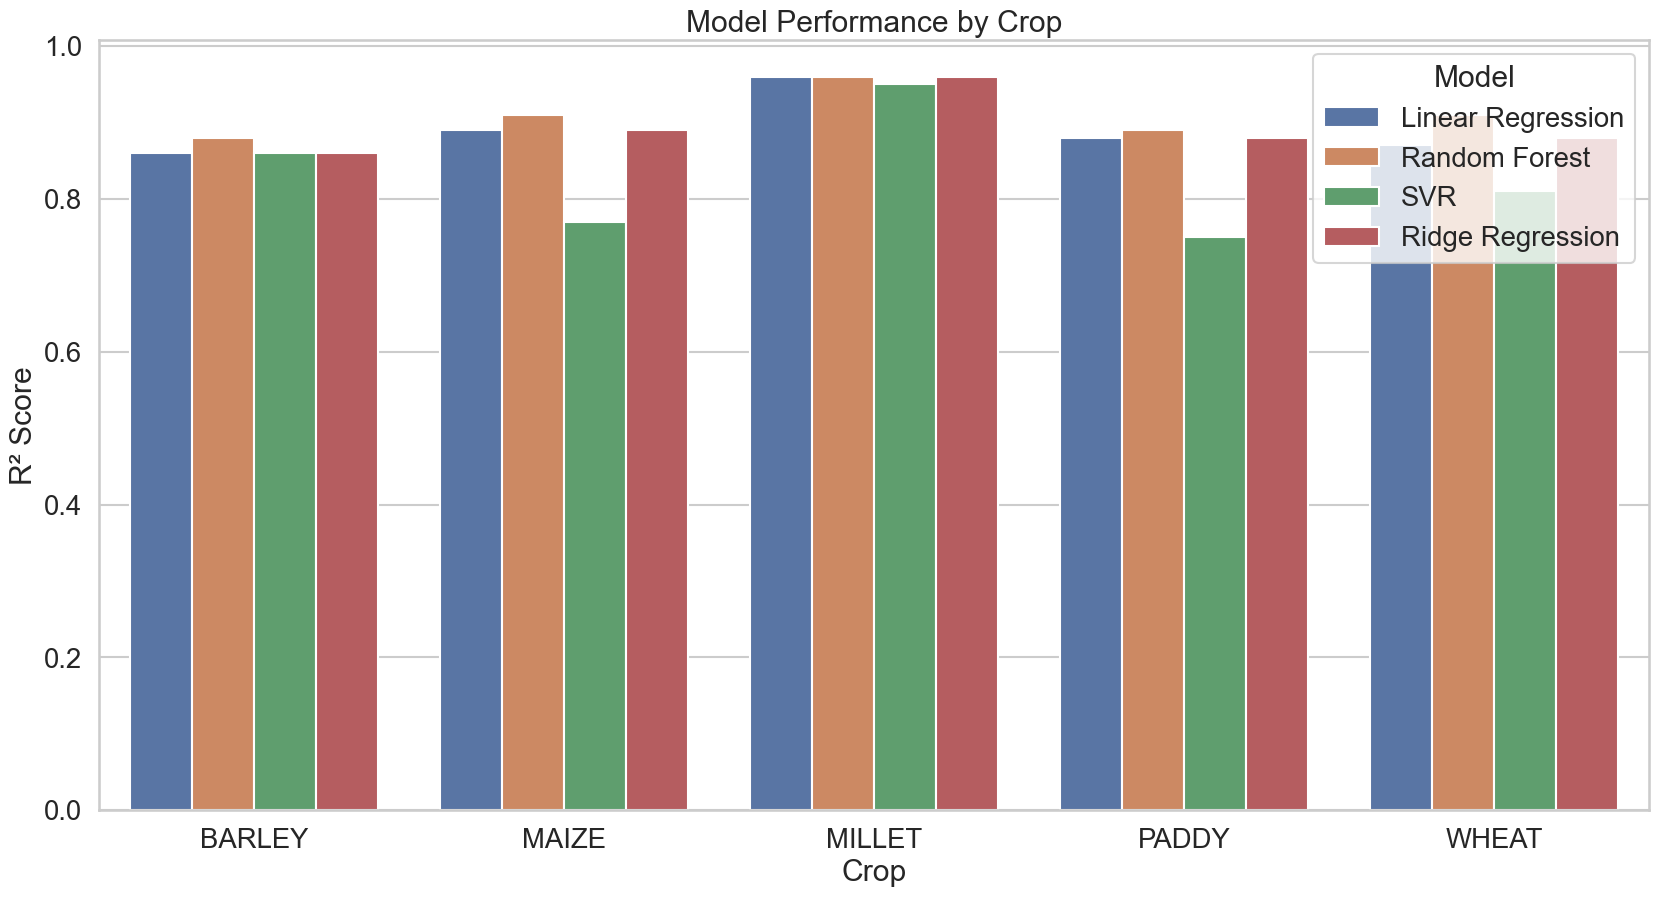

In [10]:
# Summary of all results
summary_df = summary_df.round(2)
print("Model Performance Summary:")
display(summary_df)  # Jupyter-friendly display of the summary
# Display the summary DataFrame as a clear table
plt.figure(figsize=(20, 10))
# Increase font size
sns.set_context("talk", font_scale=1.2)
# Save the plot with transparent background

sns.barplot(x="Crop", y="R²", hue="Model", data=summary_df)
plt.title("Model Performance by Crop")
plt.ylabel("R² Score")
plt.xlabel("Crop")
plt.legend(title="Model")
plt.show()
